# Training on IMDB dataset for Sentiment Analysis - Convolutional Neural Networks

## Loading the dataset

IMDB dataset having **50K movie reviews for natural language processing** or Text analytics.
This is a dataset for **binary sentiment classification** containing 50K movie reviews, **25K from each class**.

It contains two columns - 
* **review** (text)
* **sentiment** (positive or negative)

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import re
import string
import numpy as np
import pandas as pd

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer 
from nltk.tokenize import TweetTokenizer

import csv
import os
import unicodedata
import codecs

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.tokenize import word_tokenize
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model


In [4]:
# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
tpu

In [5]:
# instantiate a distribution strategy
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

In [6]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [7]:
data = pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')

In [8]:
data_X = data['review']
data_Y = data['sentiment']

## Text Preprocessing Function (for CNN)

This `process_text` function prepares raw text data for use in a Convolutional Neural Network (CNN) for text classification. It performs the following steps:

- **Contraction Expansion:** Replaces common English contractions (e.g., "isn't" to "is not") for uniformity.
- **Special Character & Emoji Removal:** Cleans out special Unicode symbols, emojis, and other unusual characters.
- **Compound Word Separation:** Fixes known concatenated words and tokenizes domain-specific compound phrases into separate words for improved parsing.
- **Text Normalization:** Converts the entire text to lowercase.
- **Prefix & HTML Removal:** Removes user mention prefixes and HTML line breaks for cleaner input.
- **Hyperlink Removal:** Deletes hyperlinks to remove noise from text data.
- **Punctuation Handling:** Ensures periods and commas are spaced properly to help downstream tokenization, while removing other punctuation symbols.
- **Whitespace Cleanup:** Replaces multiple spaces with a single space and strips unwanted whitespace from the beginning and end.

**Note:**  
Unlike previous versions intended for models like Bag-of-Words, this version leaves out stopword removal and stemming steps—these adjustments make it more suitable for deep learning models such as CNNs, which can benefit from retaining original word forms and stopwords.

The result is a clean, normalized string that preserves important sentence structure for neural network input.

In [9]:
def process_text(line):
    
    #remove short
    line=re.sub("isn't",'is not',line)
    line=re.sub("he's",'he is',line)
    line=re.sub("wasn't",'was not',line)
    line=re.sub("there's",'there is',line)
    line=re.sub("couldn't",'could not',line)
    line=re.sub("won't",'will not',line)
    line=re.sub("they're",'they are',line)
    line=re.sub("she's",'she is',line)
    line=re.sub("There's",'there is',line)
    line=re.sub("wouldn't",'would not',line)
    line=re.sub("haven't",'have not',line)
    line=re.sub("That's",'That is',line)
    line=re.sub("you've",'you have',line)
    line=re.sub("He's",'He is',line)
    line=re.sub("what's",'what is',line)
    line=re.sub("weren't",'were not',line)
    line=re.sub("we're",'we are',line)
    line=re.sub("hasn't",'has not',line)
    line=re.sub("you'd",'you would',line)
    line=re.sub("shouldn't",'should not',line)
    line=re.sub("let's",'let us',line)
    line=re.sub("they've",'they have',line)
    line=re.sub("You'll",'You will',line)
    line=re.sub("i'm",'i am',line)
    line=re.sub("we've",'we have',line)
    line=re.sub("it's",'it is',line)
    line=re.sub("don't",'do not',line)
    line=re.sub("that´s",'that is',line)
    line=re.sub("I´m",'I am',line)
    line=re.sub("it’s",'it is',line)
    line=re.sub("she´s",'she is',line)
    line=re.sub("he’s'",'he is',line)
    line=re.sub('I’m','I am',line)
    line=re.sub('I’d','I did',line)
    line=re.sub("he’s'",'he is',line)
    line=re.sub('there’s','there is',line)
    line = re.sub(r'\'ll', ' will',line)
    
    
    #special characters and emojis
    line=re.sub('\x91the','the',line)
    line=re.sub('\x97','',line)
    line=re.sub('\x84the','the',line)
    line=re.sub('\uf0b7','',line)
    line=re.sub('¡¨','',line)
    line=re.sub('\x95','',line)
    line=re.sub('\x8ei\x9eek','',line)
    line=re.sub('\xad','',line)
    line=re.sub('\x84bubble','bubble',line)
    
    # remove concated words
    line=re.sub('trivialBoring','trivial Boring',line)
    line=re.sub('Justforkix','Just for kix',line)
    line=re.sub('Nightbeast','Night beast',line)
    line=re.sub('DEATHTRAP','Death Trap',line)
    line=re.sub('CitizenX','Citizen X',line)
    line=re.sub('10Rated','10 Rated',line)
    line=re.sub('_The','_ The',line)
    line=re.sub('1Sound','1 Sound',line)
    line=re.sub('blahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblah','blah blah',line)
    line=re.sub('ResidentHazard','Resident Hazard',line)
    line=re.sub('iameracing','i am racing',line)
    line=re.sub('BLACKSNAKE','Black Snake',line)
    line=re.sub('DEATHSTALKER','Death Stalker',line)
    line=re.sub('_is_','is',line)
    line=re.sub('10Fans','10 Fans',line)
    line=re.sub('Yellowcoat','Yellow coat',line)
    line=re.sub('Spiderbabe','Spider babe',line)
    line=re.sub('Frightworld','Fright world',line)
    
    line = line.lower()
    line = re.sub(r'^nrt@[a-z]+[\s]*', '', line)
    line = re.sub(r'^rt@[a-z]+[\s]*', '', line)
    line = re.sub(r'<br />', ' ', line)
    
    # remove hyperlinks
    line = re.sub(r'https?:\/\/.*[\r\n]*', '', line)
    # remove punctuation
    line= re.sub(r"\.+",r" . ",line)
    line=re.sub(',',' , ',line)
    
    line = re.sub(r'[!"#$%&\'()*+-]', '', line)
    line = re.sub(r'[/:;<=>?@\[\]^_`{|}~\\]', '', line)
    #remove and numbers
    #line = re.sub(r'[0-9+]+','',line)
    line = re.sub(r"\s+", r" ", line).strip()
    #stopwords and stemming
    #stopwords_english = stopwords.words('english')
    #stemmer = PorterStemmer()
    #text = ""
    
    #for word in line.split():
        #if word not in stopwords_english:
        #stem_word = stemmer.stem(word)
        #text+=" "+stem_word
        #text+=" " +word
    
    return line.strip()

In [10]:
train = []

for t in data_X:
    train.append(process_text(t).strip())

## Loading Pre-trained GloVe Embeddings

GloVe (Global Vectors for Word Representation) 300d refers to pre-trained word embeddings where each word is represented by a 300-dimensional continuous vector.  
- These vectors capture semantic relationships between words based on their co-occurrence statistics in a large corpus.  
- The 300-dimensional size provides a good balance between capturing rich linguistic information and computational efficiency.  
- GloVe embeddings are widely used in NLP tasks to provide meaningful word representations that improve model performance.    
- The loaded object typically contains a dictionary that maps words to their 300-dimensional vector representations.  
- Using pre-trained embeddings helps improve model performance by providing rich word features without training from scratch.

In [11]:
glove_embeddings= np.load('../input/pickled-glove840b300d-for-10sec-loading/glove.840B.300d.pkl',allow_pickle=True)

### Preparing Text Data for Deep Learning

This code block prepares text and label data for neural network training:

- **Label Encoding:**  
  Converts class labels (`Y`) from text to integers using `LabelEncoder`, making them usable for classification models.

- **Tokenizer Setup:**  
  - Initializes a Keras `Tokenizer` with a specified vocabulary size (`vocab_size`) and an out-of-vocabulary token (`<OOV>`) to handle unknown words.
  - Fits the tokenizer on your training texts (`X`), learning a word-to-index mapping (`word_to_index`).

- **Text to Sequences:**  
  Transforms the list of text documents into sequences of integers (`X_sequences`), where each word is replaced by its corresponding index in the vocabulary.  
  Words not encountered during fitting are replaced with the OOV index.

**This preprocessing step converts raw text and class labels into numeric forms required for input into deep learning models such as CNNs, RNNs, or Transformers.**

In [12]:
#______________________Getting ready the data for training_______________________

X=train
Y=data_Y
encoder = preprocessing.LabelEncoder()
Y = encoder.fit_transform(Y)
#___________________________________________________


#_____________________________________________________
vocab_size = 100000
oov_tok= '<OOV>'

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X)
word_to_index = tokenizer.word_index

X_sequences = tokenizer.texts_to_sequences(X)

### Padding Text Sequences for Neural Network Input

Below code block prepares the tokenized text sequences (`X_sequences`) for input to a deep learning model by standardizing their lengths:

- **Max Length:** Sets the length of all sequences to a fixed size (`max_length = 400`).
- **Padding:**  
  - Sequences shorter than `max_length` are padded with zeros **at the end** (`padding='post'`) to reach the fixed length.
- **Truncating:**  
  - Sequences longer than `max_length` are truncated **at the end** (`truncating='post'`) to fit the length limit.

This ensures that all input sequences have the same length, which is **required when feeding data into models like CNNs or RNNs for training and inference.**

In [13]:
# padding to max length = 200
max_length = 400
padding_type = 'post'
trunc_type = 'post'
X_padded = pad_sequences(X_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [14]:
train_X, valid_X, train_Y, valid_Y = model_selection.train_test_split(X_padded, Y,test_size=0.2)

### One-Hot Encoding of Labels

The following code converts integer class labels (`train_Y` and `valid_Y`) into one-hot encoded vectors using Keras’ `to_categorical` function:

- **Purpose:**  
  Many neural network models for classification require labels in one-hot format instead of scalar integers.

- **How it works:**  
  - For `num_classes=2` (binary classification), each label is converted into a 2-element vector.  
  - For example, class label 0 becomes `[1, 0]` and class label 1 becomes `[0, 1]`.

- **Result:**  
  - `train_labels` and `valid_labels` contain the one-hot encoded vectors for each sample in the training and validation sets, respectively, ready for use during model training.

This step is essential when using categorical loss functions like `categorical_crossentropy` in Keras models.

In [15]:
train_labels = to_categorical(train_Y,num_classes=2)
valid_labels = to_categorical(valid_Y,num_classes=2)

In [16]:
train_labels.shape

(40000, 2)

In [17]:
valid_labels.shape

(10000, 2)

In [18]:
train_X.shape

(40000, 400)

### Embedding Matrix with GloVe Vectors

This code creates an embedding matrix for vocabulary using pre-trained 300-dimensional GloVe vectors:

- Initializes a zero matrix of shape `(vocab_size, 300)`.
- Fills each row with the GloVe embedding for the corresponding word if available.
- Words not in GloVe keep zero vectors.

This matrix can initialize model’s embedding layer to use rich pre-trained word representations.


In [19]:
vocab_size = len(word_to_index)
embeddings_matrix = np.zeros((vocab_size, 300))
for word, i in list(word_to_index.items())[:vocab_size]:
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector

In [20]:
embeddings_matrix.shape

(148518, 300)

## CNN Model Architecture Explanation

Below code builds a text classification model using Keras with the following structure:

- **Embedding Layer:**  
  - Converts word indices into dense 300-dimensional vectors using the pre-trained GloVe embeddings (`embeddings_matrix`).
  - `trainable=False` keeps the embeddings fixed during training.
  - `input_length=400` sets each input sequence to be 400 tokens long.

- **Conv1D Layer:**  
  - Applies 160 filters (feature detectors) with a kernel size of 10 over the sequence.
  - Extracts local n-gram features (subsequences of 10 words) using the ReLU activation function.

- **MaxPooling1D Layer:**  
  - Downsamples the output of the convolution by taking the maximum value over windows of size 3, helping to reduce dimensionality and focus on the most important features.

- **Flatten Layer:**  
  - Converts the 2D matrix output from the previous layer into a 1D vector to prepare it for the dense layer(s).

- **Dropout Layer:**  
  - Randomly sets 40% of inputs to zero during training (`Dropout(0.4)`).
  - Helps prevent overfitting by encouraging the network to be less dependent on specific features.

- **Dense Output Layer:**  
  - Fully connected layer with 2 units (for binary or two-class classification).
  - Uses `softmax` activation to produce probabilities for each class.

**Model Summary**  
This architecture combines pre-trained word embeddings, 1D convolution for local feature extraction, pooling for dimension reduction, and a dense output layer for classification. It is well-suited for text classification tasks on sequences padded to length 400, and it utilizes TPU acceleration for training.


In [39]:
embedding_dim = 300
with tpu_strategy.scope():
    model = tf.keras.Sequential([tf.keras.layers.Embedding(vocab_size,embedding_dim ,
                embeddings_initializer=tf.keras.initializers.Constant(embeddings_matrix),input_length=400,trainable=False),
            
            tf.keras.layers.Conv1D(filters=160, kernel_size=10, padding='valid', activation='relu'),
            tf.keras.layers.MaxPooling1D(pool_size=3),               
            tf.keras.layers.Flatten(),
            #tf.keras.layers.Dense(32,activation='relu'),
            tf.keras.layers.Dropout(0.4),
            tf.keras.layers.Dense(2, activation='softmax')])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 400, 300)          44555400  
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 391, 160)          480160    
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 130, 160)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 20800)             0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 20800)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 41602     
Total params: 45,077,162
Trainable params: 521,762
Non-trainable params: 44,555,400
____________________________________

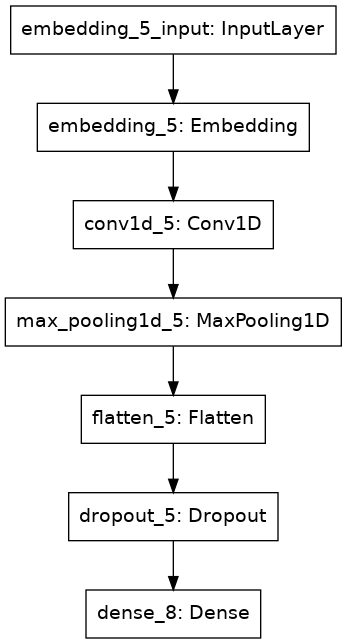

In [40]:
tf.keras.utils.plot_model(model)

In [41]:
num_epochs=20
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0005)
loss = tf.keras.losses.BinaryCrossentropy()
metric = tf.keras.metrics.BinaryAccuracy()
model.compile(loss=loss, 
          optimizer=optimizer, metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
#mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
#with tf.device('/device:GPU:0'):
history = model.fit(train_X,train_labels , epochs=num_epochs,validation_data=(valid_X,valid_labels),
                        batch_size=128*4, callbacks=[es,],verbose=2)

Epoch 1/20
79/79 - 14s - loss: 0.5582 - accuracy: 0.7128 - val_loss: 0.4344 - val_accuracy: 0.8031
Epoch 2/20
79/79 - 1s - loss: 0.3760 - accuracy: 0.8406 - val_loss: 0.3536 - val_accuracy: 0.8501
Epoch 3/20
79/79 - 1s - loss: 0.3212 - accuracy: 0.8690 - val_loss: 0.3979 - val_accuracy: 0.8311
Epoch 4/20
79/79 - 1s - loss: 0.2887 - accuracy: 0.8863 - val_loss: 0.3194 - val_accuracy: 0.8670
Epoch 5/20
79/79 - 1s - loss: 0.2441 - accuracy: 0.9076 - val_loss: 0.3208 - val_accuracy: 0.8649
Epoch 6/20
79/79 - 1s - loss: 0.2101 - accuracy: 0.9255 - val_loss: 0.3098 - val_accuracy: 0.8720
Epoch 7/20
79/79 - 1s - loss: 0.1750 - accuracy: 0.9413 - val_loss: 0.3673 - val_accuracy: 0.8540
Epoch 8/20
79/79 - 1s - loss: 0.1510 - accuracy: 0.9521 - val_loss: 0.3352 - val_accuracy: 0.8651
Epoch 9/20
79/79 - 1s - loss: 0.1228 - accuracy: 0.9659 - val_loss: 0.3185 - val_accuracy: 0.8711
Epoch 10/20
79/79 - 1s - loss: 0.1058 - accuracy: 0.9704 - val_loss: 0.3676 - val_accuracy: 0.8584
Epoch 11/20
79/79 

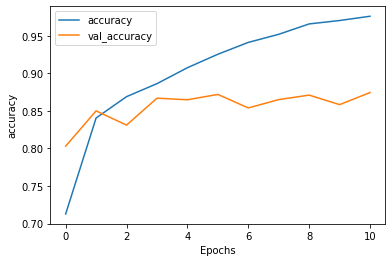

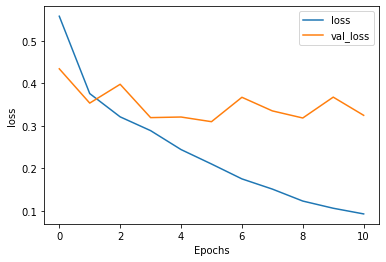

In [42]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [43]:
y_pred=model.predict(valid_X)
y_pred_classes = np.argmax(y_pred, axis=-1)

In [44]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef

In [45]:
accuracy = accuracy_score(valid_Y, y_pred_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(valid_Y, y_pred_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(valid_Y, y_pred_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(valid_Y, y_pred_classes)
print('F1 score: %f' % f1)
# Matthews Correaltion Coefficient
mcc =  matthews_corrcoef(valid_Y, y_pred_classes)
print('MCC : %f' % mcc)

Accuracy: 0.874500
Precision: 0.880692
Recall: 0.863434
F1 score: 0.871978
MCC : 0.749067


In [46]:
kappa = cohen_kappa_score(valid_Y, y_pred_classes)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(valid_Y,y_pred_classes)
print('ROC AUC: %f' % auc)
print("confusion matrix:")
matrix = confusion_matrix(valid_Y, y_pred_classes)
print(matrix)

Cohens kappa: 0.748926
ROC AUC: 0.874390
confusion matrix:
[[4471  579]
 [ 676 4274]]
